In [2]:
!pip install geemap pycrs cartopy --quiet --no-cache-dir

In [1]:
import ee
import geemap
import matplotlib.pyplot as plt
import cartopy
from geemap import cartoee

import numpy as np
import pandas as pd
from scipy.stats import norm

In [2]:
ee.Initialize(project='ee-lc-trends')

# Precipitation

In [3]:
roi = ee.FeatureCollection("FAO/GAUL/2015/level0").filter(ee.Filter.eq('ADM0_NAME', 'Afghanistan'))

start_date = '1990-01-01'
end_date = '2000-12-31'

precipt = ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY").filter(ee.Filter.date(start_date, end_date))
precipt

In [ ]:
precipt = precipt.select('precipitation')
precipt = precipt.mean()
precipt = precipt.clip(roi)
visPrecipt = {
    "min": 0,
    "max": 17,
    "palette": ['001137', '0aab1e', 'e7eb05', 'ff4a2d', 'e90000'],
}

In [ ]:
fig = plt.figure(figsize=(15, 10))
bbox = [59.41, 29.107, 75.02, 38.80]

ax = cartoee.get_map(precipt, vis_params=visPrecipt, region=bbox)
cartoee.add_gridlines(ax, interval=1, xtick_rotation=0, linestyle=":")

ax.set_title(label='1990-2000', fontsize=15)

# Elevation

In [ ]:
dem = ee.Image("NASA/NASADEM_HGT/001").select('elevation')
visDEM = {
    min: 0,
    max: 2000,
}

In [ ]:
fig = plt.figure(figsize=(15, 10))
bbox = [59.41, 29.107, 75.02, 38.80]

ax = cartoee.get_map(dem, vis_params=visDEM, region=bbox)
cartoee.add_gridlines(ax, interval=1, xtick_rotation=0, linestyle=":")

ax.set_title(label='1990-2000', fontsize=15)

# Absorbed Photosyntetically Activation Radiation (APAR) 
From the [source](https://www.mdpi.com/2072-4292/11/5/595#)

## NDVI

In [ ]:
landsat = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2').filterDate(start_date, end_date).filterBounds(roi).filter(ee.Filter.lt('CLOUD_COVER', 20))
landsat = landsat.reduce(ee.Reducer.percentile([20])).clip(roi)
landat = landsat.multiply(2.75e-05).add(-0.2)

ndvi = landsat.expression('(NIR-RED)/(NIR+RED)', {'NIR':landsat.select('SR_B4_p20'),'RED':landsat.select('SR_B3_p20')}).rename(['ndvi'])
landsat = landsat.addBands(ndvi)
landsat = landsat.select(['SR_B3_p20', 'SR_B2_p20', 'SR_B1_p20', 'ndvi'])
landsat

## Light Use Efficiency

# SPI in Rangeland

In [4]:
roi = ee.FeatureCollection("FAO/GAUL/2015/level0").filter(ee.Filter.eq('ADM0_NAME', 'Afghanistan'))
start_date = "1990-01-01"
end_date = "1990-02-01"

# Add data of Climate Projection under SPP Scenarios
dataset = ee.ImageCollection("NASA/GDDP-CMIP6").filterDate(start_date, end_date)
dataset = dataset.filterMetadata('model', 'equals', 'ACCESS-CM2')
precipt = dataset.select('pr').mean()
precipt = precipt.multiply((60*60*24)).clip(roi)

In [5]:
visPrecipt = {
    'min': 0,
    'max': 5,
    'palette': ['blue', 'red'],
}

m = geemap.Map()
m.centerObject(roi, 6)
m.addLayer(precipt, visPrecipt, name="Rate of Change in Precipitation")

In [6]:
precipt_month = []
for year in range(1990, 2020):
    for month in range(1, 12+1):
        dataset = ee.ImageCollection('NASA/GDDP-CMIP6')
        dataset = dataset.filter(ee.Filter.calendarRange(year, year, 'year'))
        dataset = dataset.filter(ee.Filter.calendarRange(month, month, 'month'))
        dataset = dataset.filterMetadata('model', 'equals', 'ACCESS-CM2')

        precipt_mean = dataset.select('pr').mean().multiply((60*60*24)).clip(roi)
        precipt_month.append(precipt_mean)

precipt_month_col = ee.ImageCollection(precipt_month)
precipt_month_col

In [7]:
sample = ee.Geometry.Point([65, 32])

def get_precipt_atpoint(image):
    return image.sampleRegions(sample, scale=27830).first()

precipt_atpoint = precipt_month_col.map(get_precipt_atpoint)
precipt_vals = np.array(precipt_atpoint.aggregate_array('pr').getInfo())
print(precipt_vals.shape)

(360,)


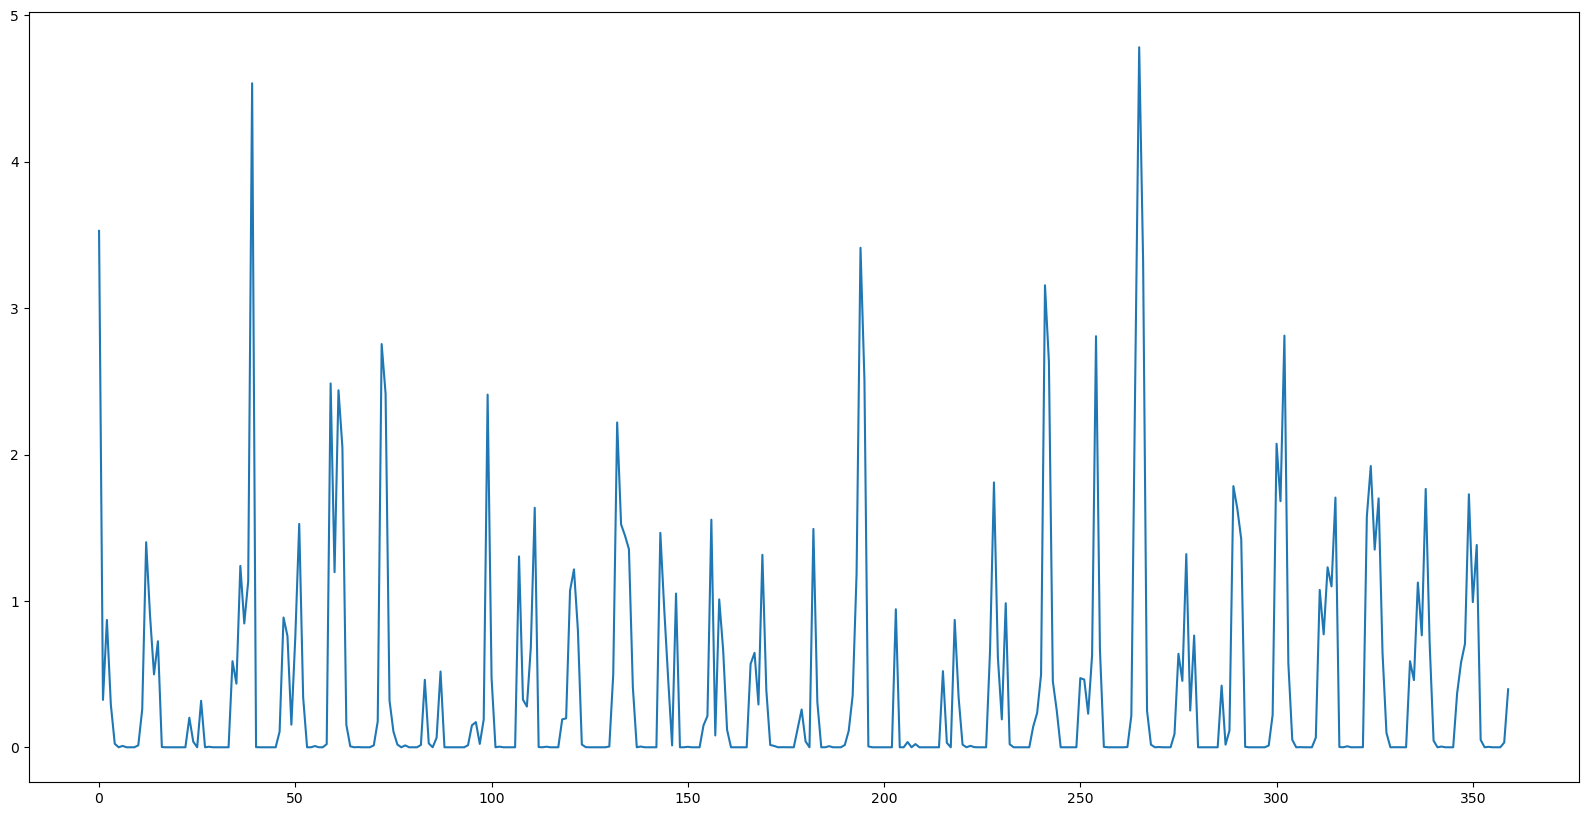

In [8]:
plt.figure(figsize=(20,10))
plt.plot(precipt_vals)
plt.show()

## Calculate SPI

In [9]:
def calculate_spi(precipt_in, scale):
    precipt_vec = np.copy(precipt_in)
    precipt_vec[scale-1:] = np.convolve(precipt_vec, np.ones(scale, dtype=int), 'valid')
    precipt_vec[:scale-1] = np.nan

    spi_vec = np.zeros_like(precipt_vec)
    for month1 in range(0, 11+1):
        precipt_vec_month = precipt_vec[month1::12]
        spi_vec_month = np.zeros_like(precipt_vec_month)

        for idx, val1 in enumerate(precipt_vec_month):
            if np.isnan(val1):
                spi_vec_month[idx] = np.nan
            else:
                bp = np.sum(precipt_vec_month<=val1)
                spi_vec_month[idx] = norm.ppf((bp-0.44)/(len(precipt_vec_month)+0.12))
        spi_vec[month1::12] = spi_vec_month
    return spi_vec

In [10]:
spi_vals = calculate_spi(precipt_vals, 3)
print(spi_vals.shape)

(360,)


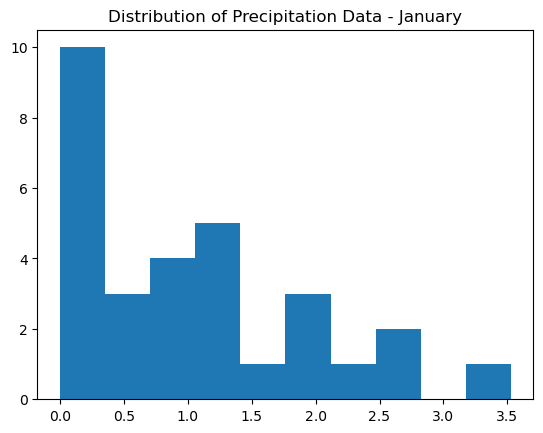

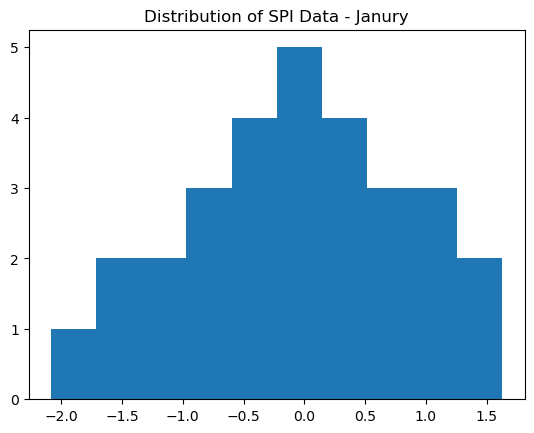

In [11]:
plt.hist(precipt_vals[0::12])
plt.title('Distribution of Precipitation Data - January')
plt.show()

plt.hist(spi_vals[0::12])
plt.title('Distribution of SPI Data - Janury')
plt.show()

In [ ]:
plt.figure(figsize=(10,5))
plt.bar(np.arange(len(spi_vals)), spi_vals)
plt.show()

# SPI in Climate Change

In [ ]:
def calculate_spi(precipt_in, scale):
    precip_vec = np.copy(precipt_in)
    

In [ ]:
def get_precipt_monthlyCol(startY, endY, scenario):
    precipt_month = []
    for year in range(startY, endY+1):
        for month in range(1, 12+1):
            dataset = ee.ImageCollection('NASA/GDDP-CMIP6')
            dataset = dataset.filter(ee.Filter.calendarRange(year, year, 'year'))
            dataset = dataset.filter(ee.Filter.calendarRange(month, month, 'year'))
            dataset = dataset.filterMetadata('model', 'equals', 'ACCESS-CM2')
            dataset = dataset.filterMetadata('scenario', 'equals', scenario)

            precipt_mean = dataset.select('pr').mean()
            precipt_month.append(precipt_mean)
    precipt_month_col = ee.ImageCollection(precipt_month)
    return precipt_month_col


In [ ]:
precipt_col_hist = get_precipt_monthlyCol(1985, 2014, 'historical')
precipt_col_ssp245 = get_precipt_monthlyCol(2015, 2044, 'ssp445')

precipt_col_all = precipt_col_hist.merge(precipt_col_ssp245)

precipt_col_all

In [ ]:
sample = ee.Geometry.Point([66.91, 36.76])

def get_precipt_atpoint(image):
    return image.sampleRegions(sample, scale=27830).first()

precipt_atpoint = precipt_col_all.map(get_precipt_atpoint)
precipt_vals = np. array(precipt_atpoint.aggregate_array('pr').getInfo())
print(precipt_vals.shape)